In [3]:
from time import strftime, gmtime, localtime

import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
#conda install -c conda-forge xgboost
import xgboost

import statsmodels.api as sm

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
#sns.set(rc={'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'patch.linewidth': 1})
%matplotlib inline

random_state = 42
np.random.seed(random_state)

print(strftime("Starting: %Y-%m-%d %H:%M:%S", localtime()))

#possible TODOs - 
# add catboost, lightboost, keras or MLP classifier
# tune classifiers
# run ensemble


Starting: 2018-11-18 10:31:40


In [4]:
data = pd.read_pickle("rank.pickle")
data.sort_values(["GVKEY", "DATETIME"],inplace=True)
data.reset_index(inplace=True)
data = data[["DATETIME","GVKEY","INDUSTRY","VALUE_RANK","MOMENTUM_RANK","RET"]]
data

,DATETIME,GVKEY,INDUSTRY,VALUE_RANK,MOMENTUM_RANK,RET
0,1989-10-31,1004,24,2,5,0.034464
1,1989-11-30,1004,24,2,7,-0.046980
2,1989-12-31,1004,24,2,8,0.014085
3,1990-01-31,1004,24,2,7,-0.121667
4,1990-02-28,1004,24,2,5,-0.011905
5,1990-03-31,1004,24,2,6,-0.036145
6,1990-04-30,1004,24,2,4,-0.279167
7,1963-01-31,1010,25,9,9,0.047002
8,1963-02-28,1010,25,9,8,0.038700
9,1963-03-31,1010,25,9,8,-0.009009


In [13]:
# shift MOMENTUM_RANK by groupby to forecast next month's momentum rank ()
# just show results for now
data[["DATETIME", "GVKEY","MOMENTUM_RANK"]].groupby("GVKEY").shift(-1)

,DATETIME,MOMENTUM_RANK
0,1989-11-30,7.0
1,1989-12-31,8.0
2,1990-01-31,8.0
3,1990-02-28,7.0
4,1990-03-31,7.0
5,1990-04-30,7.0
6,NaT,NaN
7,1963-02-28,8.0
8,1963-03-31,8.0
9,1963-04-30,9.0


In [14]:
data["MOMENTUM_RESPONSE"] = data[["DATETIME", "GVKEY","MOMENTUM_RANK"]].groupby("GVKEY").shift(-1)["MOMENTUM_RANK"]
data

,DATETIME,GVKEY,INDUSTRY,VALUE_RANK,MOMENTUM_RANK,RET,MOMENTUM_RESPONSE
0,1989-10-31,1004,24,2,7,0.034464,7.0
1,1989-11-30,1004,24,2,7,-0.046980,8.0
2,1989-12-31,1004,24,2,8,0.014085,8.0
3,1990-01-31,1004,24,2,8,-0.121667,7.0
4,1990-02-28,1004,24,2,7,-0.011905,7.0
5,1990-03-31,1004,24,2,7,-0.036145,7.0
6,1990-04-30,1004,24,2,7,-0.279167,NaN
7,1963-01-31,1010,25,8,9,0.047002,8.0
8,1963-02-28,1010,25,8,8,0.038700,8.0
9,1963-03-31,1010,25,8,8,-0.009009,9.0


In [15]:
data.dropna(inplace=True)
data["MOMENTUM_RESPONSE"] = data[["MOMENTUM_RESPONSE"]].astype(int)
data

,DATETIME,GVKEY,INDUSTRY,VALUE_RANK,MOMENTUM_RANK,RET,MOMENTUM_RESPONSE
0,1989-10-31,1004,24,2,7,0.034464,7
1,1989-11-30,1004,24,2,7,-0.046980,8
2,1989-12-31,1004,24,2,8,0.014085,8
3,1990-01-31,1004,24,2,8,-0.121667,7
4,1990-02-28,1004,24,2,7,-0.011905,7
5,1990-03-31,1004,24,2,7,-0.036145,7
7,1963-01-31,1010,25,8,9,0.047002,8
8,1963-02-28,1010,25,8,8,0.038700,8
9,1963-03-31,1010,25,8,8,-0.009009,9
10,1963-04-30,1010,25,8,9,0.084848,8


In [16]:
X = data[["VALUE_RANK","MOMENTUM_RANK"]].values
#X = data[["VALUE", "MOMENTUM"]].values
X = np.hstack((X, pd.get_dummies(data["INDUSTRY"]).values))
y = data["MOMENTUM_RESPONSE"].values
X.shape, y.shape

((577909, 51), (577909,))

In [17]:
# create train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [18]:
# shouldn't necessarily scale since we have deciles
# but should recalc deciles since we aren't balanced
# put xval and holdout at end

xval_index = len(data.loc[data["DATETIME"] > pd.to_datetime("2013-01-01")])
test_index = len(data.loc[data["DATETIME"] > pd.to_datetime("2016-01-01")])

total_obs, predictors = X.shape
train_end = total_obs-xval_index
xval_end =  total_obs-test_index

train_indexes      = list(range(train_end))
train_xval_indexes = list(range(xval_end))
xval_indexes       = list(range(train_end,xval_end))
test_indexes       = list(range(xval_end, total_obs))

y=y.reshape(total_obs,1)
X_train = X[train_indexes]
y_train = y[train_indexes]

X_train_xval = X[train_xval_indexes]
y_train_xval = y[train_xval_indexes]

X_xval = X[xval_indexes]
y_xval = y[xval_indexes]

X_test = X[test_indexes]
y_test = y[test_indexes]

print(total_obs)
print(X_train.shape)
print(X_xval.shape)
print(X_test.shape)
print(X_train_xval.shape)

# scale
scaler = preprocessing.StandardScaler()
# train scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# transform only
X_train_xval_scaled = scaler.transform(X_train_xval)
X_xval_scaled = scaler.transform(X_xval)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# ys
scaler = preprocessing.StandardScaler()
y_train_scaled = scaler.fit_transform(y_train)
# transform only!
y_train_xval_scaled = scaler.transform(y_train_xval)
y_xval_scaled = scaler.transform(y_xval)
y_test_scaled = scaler.transform(y_test)



577909
(517654, 51)
(36755, 51)
(23500, 51)
(554409, 51)


/home/druce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/druce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/druce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/druce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/druce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data w

Train Accuracy: 0.420878
Xval Accuracy: 0.432077


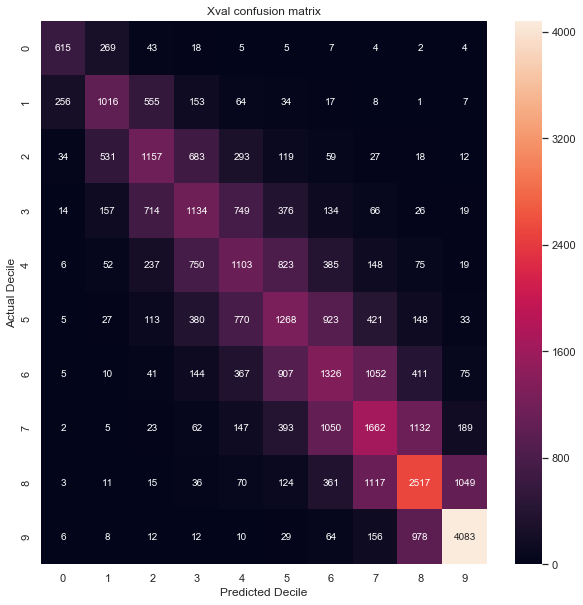

In [23]:
# naive model - predict = momentum
y_train_pred = X_train[:,1]
train_acc = accuracy_score(y_train, y_train_pred)
print ("Train Accuracy: %0.6f" % train_acc)

y_xval_pred = X_xval[:,1]
xval_acc = accuracy_score(y_xval, y_xval_pred)
print ("Xval Accuracy: %0.6f" % xval_acc)

def conf_matrix_heatmap(y_xval, y_xval_pred):
    conf_matrix = confusion_matrix(y_xval, y_xval_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.ylabel('Actual Decile')
    plt.xlabel('Predicted Decile')
    plt.title("Xval confusion matrix")
    plt.show()

conf_matrix_heatmap(y_xval, y_xval_pred)

Train Accuracy: 0.420878
Xval Accuracy: 0.432077


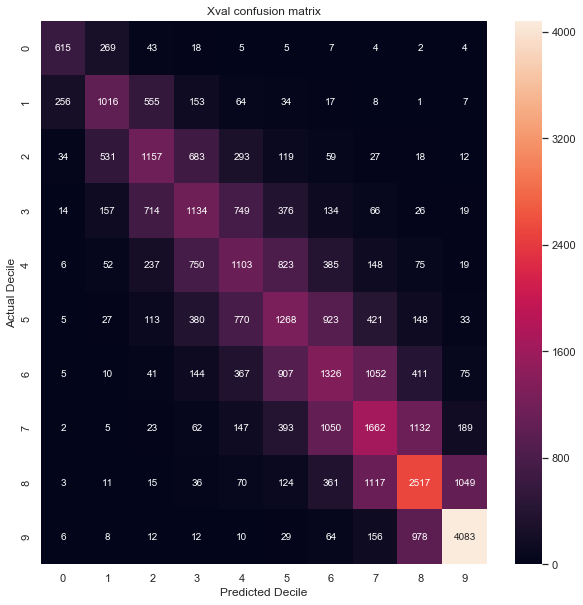

In [27]:
# 1 feature - momentum - same as above but do LR on it
model = LogisticRegression(C=1e06, solver='saga', multi_class='multinomial', max_iter=10000) # minimal regularization

# Fit the model
nrows, ncols = X_train.shape
X_train1 = X_train[:,1].reshape(nrows, 1)
nrows, ncols = X_xval.shape
X_xval1 = X_xval[:,1].reshape(nrows,1)

model.fit(X_train1, y_train[:,0])

y_train_pred = model.predict(X_train1)
print ("Train Accuracy: %0.6f" % accuracy_score(y_train, y_train_pred))
y_xval_pred = model.predict(X_xval1)
xval_acc = accuracy_score(y_xval, y_xval_pred)
print ("Xval Accuracy: %0.6f" % xval_acc)

conf_matrix = confusion_matrix(y_xval, y_xval_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Decile')
plt.xlabel('Predicted Decile')
plt.title("Xval confusion matrix")
plt.show()


Train Accuracy: 0.420760
Xval Accuracy: 0.431506


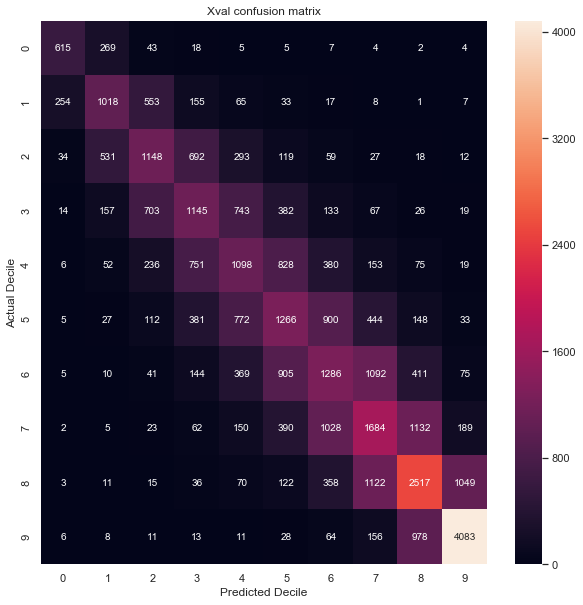

In [26]:
model = LogisticRegression(C=1e06, solver='saga', multi_class='multinomial', max_iter=10000) # minimal regularization

# Fit the model
model.fit(X_train, y_train[:,0])

y_train_pred = model.predict(X_train)
print ("Train Accuracy: %0.6f" % accuracy_score(y_train, y_train_pred))
y_xval_pred = model.predict(X_xval)
xval_acc = accuracy_score(y_xval, y_xval_pred)
print ("Xval Accuracy: %0.6f" % xval_acc)


conf_matrix = confusion_matrix(y_xval, y_xval_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Decile')
plt.xlabel('Predicted Decile')
plt.title("Xval confusion matrix")
plt.show()


In [22]:
# Same but let's CV the complexity/regularization param

print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    

model = LogisticRegressionCV(solver='saga', multi_class='multinomial', # one-vs-rest
                             cv=[(train_indexes, xval_indexes)], # use our 1-fold time-based xval
                             max_iter=10000, 
                             n_jobs=4) 

# Fit the model
model.fit(X_train_xval, y_train_xval[:,0])

y_train_pred = model.predict(X_train)
print ("Train Accuracy: %0.6f" % accuracy_score(y_train, y_train_pred))
y_xval_pred = model.predict(X_xval)

conf_matrix = confusion_matrix(y_xval, y_xval_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Decile')
plt.xlabel('Predicted Decile')
plt.title("Xval confusion matrix")
plt.show()

print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    


Start: 2018-10-22 15:10:57


KeyboardInterrupt: 

In [ ]:
# grid search harness
def build_grid_search_est(model, X, y, params, cv):
    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    
    #n_jobs = 4 because 8 or -1 maxes out memory and dies
    grid_est = GridSearchCV(model, 
                            param_grid=params, 
                            cv=cv, 
                            scoring="accuracy", 
                            n_jobs=4)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        tempdf = df.groupby(['param_' + param]).mean().reset_index()
        plt.semilogx(tempdf['param_' + param], tempdf.mean_test_score)
        plt.show()
        
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    return grid_est

In [ ]:
# grid search on LogisticRegression to find best C
# should be same as LogisticRegressionCV

print("LogisticRegression Model:")
params = {
    "C": np.logspace(-4, 4, 17)
}

print("C values to test")
print(params['C'])

grid_est = build_grid_search_est(LogisticRegression(solver='saga',
                                                    multi_class='multinomial'), 
                                 X_train_xval, y_train_xval[:,0], 
                                 params, 
                                 cv=[(train_indexes, xval_indexes)])

LR_best_c = grid_est.best_params_['C']
print(grid_est.best_params_)
print(grid_est.best_estimator_)

pd.DataFrame(grid_est.cv_results_).sort_values("mean_test_score", ascending=False)


In [ ]:
# rerun best estimator on full dataset

def run_one_model(model, X_train, y_train, X_xval, y_xval):

    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    # Build the model

    # Fit the model
    model.fit(X_train, y_train[:,0])

    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print ("Train Accuracy: %0.6f" % train_acc)
    y_xval_pred = model.predict(X_xval)
    xval_acc = accuracy_score(y_xval, y_xval_pred)
    print ("Xval Accuracy: %0.6f" % xval_acc)

    conf_matrix = confusion_matrix(y_xval, y_xval_pred)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.ylabel('Actual Decile')
    plt.xlabel('Predicted Decile')
    plt.title("Xval confusion matrix")
    plt.show()

    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    
    return model, (train_acc, xval_acc)

In [ ]:
model, _ =run_one_model(LogisticRegression(C=LR_best_c,
                                           multi_class='multinomial',
                                           solver='saga'),
                        X_train, y_train,
                        X_xval, y_xval)

print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    

In [ ]:
# enumerate classifiers
from sklearn.base import ClassifierMixin
from sklearn.utils.testing import all_estimators
#classifiers=[est for est in all_estimators() if not issubclass(est[1], ClassifierMixin)]

estimators = []
for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

In [ ]:
my_classifiers = [("LogisticRegression", sklearn.linear_model.logistic.LogisticRegression(C=LR_best_c,
                                                                                          multi_class='multinomial',
                                                                                          solver='saga',
                                                                                          max_iter=10000,
                                                                                          n_jobs=4)),
                 ("RandomForest", sklearn.ensemble.forest.RandomForestClassifier(n_estimators=100,n_jobs=4)),
                 ("ExtraTrees", sklearn.ensemble.forest.ExtraTreesClassifier(n_estimators=100,n_jobs=4)),
                 ("GradientBoost", sklearn.ensemble.gradient_boosting.GradientBoostingClassifier(n_estimators=100)),
                 ("AdaBoost", sklearn.ensemble.weight_boosting.AdaBoostClassifier(n_estimators=100)),
                 ("BernoulliNB", sklearn.naive_bayes.BernoulliNB()),
                 ("GaussianNB", sklearn.naive_bayes.GaussianNB()),
                 ("XGBM", xgboost.sklearn.XGBClassifier(n_estimators=300, 
                                                        max_depth=5, 
                                                        subsample=0.5,
                                                        learning_rate=0.6,
                                                        n_jobs=4
                                                       ))
                ]

clf_accuracies = []
clf_names = []
for desc, clf in my_classifiers:
    print("%s" % desc)
    model, scores = run_one_model(clf,
                                  X_train, y_train,
                                  X_xval, y_xval)
    train_acc, xval_acc = scores
    clf_accuracies.append(xval_acc)
    clf_names.append(desc)
    
    # run prediction on entire dataset
    data[desc] = model.predict(X)
    
data.to_pickle("data_class_fcast.pickle")

pd.DataFrame(clf_names, clf_accuracies)    

In [ ]:
# evaluate in test
"AdaBoost"

clf = sklearn.ensemble.weight_boosting.AdaBoostClassifier(n_estimators=100)
model, scores = run_one_model(clf,
                              X_train, y_train,
                              X_xval, y_xval)
train_acc, xval_acc = scores
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print ("Xval Accuracy: %0.6f" % test_acc)

conf_matrix_heatmap(y_test, y_test_pred)    


In [ ]:
# tune Random Forest
# from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = sklearn.ensemble.forest.RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 64, cv = kfold, verbose=2, random_state=42, n_jobs = 4)
# # Fit the random search model
# rf_random.fit(X_train_scaled, y_train)
# rf_random.best_params_


In [ ]:
print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))
